In [ ]:
!curl --compressed 'https://limu.ait.kyushu-u.ac.jp/~agri/komatsuna/multi_label.zip' > multi_label.zip
!curl --compressed 'https://limu.ait.kyushu-u.ac.jp/~agri/komatsuna/multi_plant.zip' > multi_plant.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2079k  100 2079k    0     0   778k      0  0:00:02  0:00:02 --:--:--  779k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  108M  100  108M    0     0  1247k      0  0:01:28  0:01:28 --:--:-- 1384k


In [ ]:
!unzip multi_label.zip
!unzip multi_plant.zip

Archive:  multi_label.zip
  inflating: multi_label/label_01_02_005_04.png  
  inflating: multi_label/label_00_04_000_00.png  
  inflating: multi_label/label_00_04_000_01.png  
  inflating: multi_label/label_00_04_000_02.png  
  inflating: multi_label/label_00_04_000_03.png  
  inflating: multi_label/label_00_04_000_04.png  
  inflating: multi_label/label_00_04_000_05.png  
  inflating: multi_label/label_00_04_001_00.png  
  inflating: multi_label/label_00_04_001_01.png  
  inflating: multi_label/label_00_04_001_02.png  
  inflating: multi_label/label_00_04_001_03.png  
  inflating: multi_label/label_00_04_001_04.png  
  inflating: multi_label/label_00_04_001_05.png  
  inflating: multi_label/label_00_04_002_00.png  
  inflating: multi_label/label_00_04_002_01.png  
  inflating: multi_label/label_00_04_002_02.png  
  inflating: multi_label/label_00_04_002_03.png  
  inflating: multi_label/label_00_04_002_04.png  
  inflating: multi_label/label_00_04_002_05.png  
  inflating: multi_label

In [ ]:
import os
from random import randint
import copy

import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
low_H = 40  # Lower bound for Hue
low_S = 30  # Lower bound for Saturation
low_V = 30  # Lower bound for Value
high_H = 75  # Upper bound for Hue
high_S = 255 # Upper bound for Saturation
high_V = 255 # Upper bound for Value

In [ ]:
def HSV_filtering_and_watershed(input_im, low_H, low_S, low_V, high_H, high_S, high_V):
        # Convert to HSV and apply thresholding
        hsv_image = cv.cvtColor(input_im, cv.COLOR_BGR2HSV)
        im_threshold = cv.inRange(hsv_image, (low_H, low_S, low_V), (high_H, high_S, high_V),cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

        # Morphological operations
        kernel = np.ones((3, 3), np.uint8)
        opening = cv.morphologyEx(im_threshold, cv.MORPH_OPEN, kernel, iterations=5)
        sure_bg = cv.dilate(opening, kernel, iterations=7)

        # Distance transform and sure foreground
        dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
        _, sure_fg = cv.threshold(dist_transform, 0.3 * dist_transform.max(), 255, 0)
        sure_fg = np.uint8(sure_fg)

        # Unknown region
        unknown = cv.subtract(sure_bg, sure_fg)

        # Markers and watershed
        _, markers = cv.connectedComponents(sure_fg)
        markers = markers + 1
        markers[unknown == 255] = 0
        markers = cv.watershed(input_im, markers)

        # Visualization
        disco_mode = False
        input_im[markers == -1] = [255, 0, 0]  # Mark boundaries
        for i in range(2, markers.max() + 1):
          input_im[markers == i] = [
            randint(0, 255), randint(0, 255), randint(0, 255)
          ] if disco_mode else [
            (40 + i * 40) % 255, (i * 40) % 255, (50 + i * 40) % 255
          ]

        # Create mask
        mask = copy.deepcopy(input_im)
        mask[markers < 2] = [0, 0, 0]  # Black out background

        return mask, input_im, im_threshold


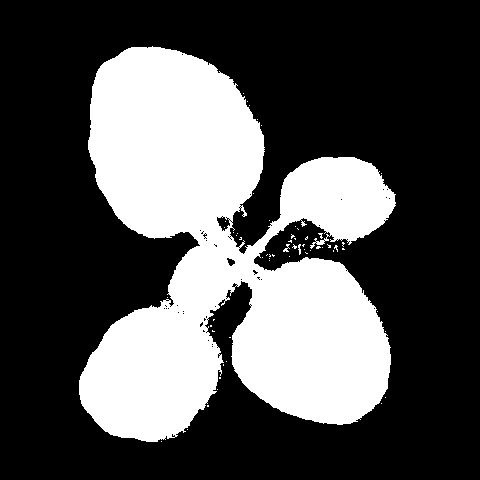

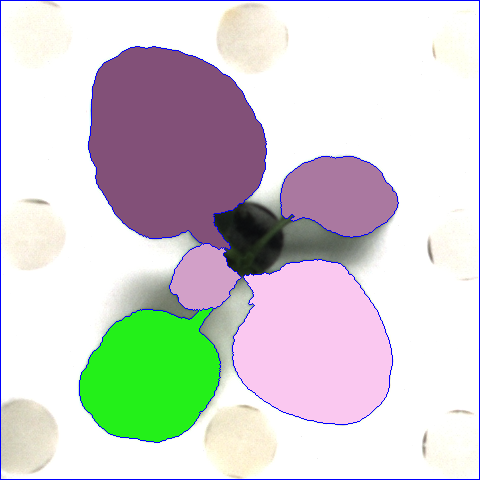

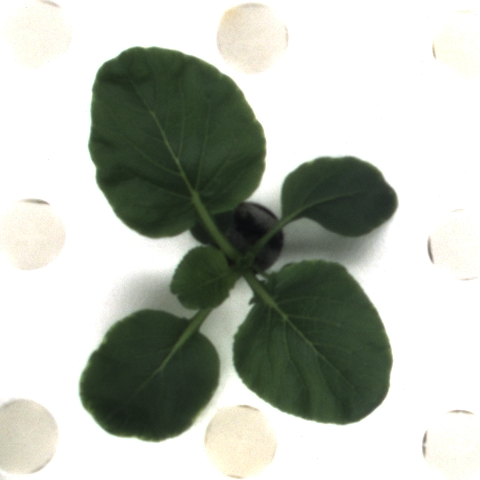

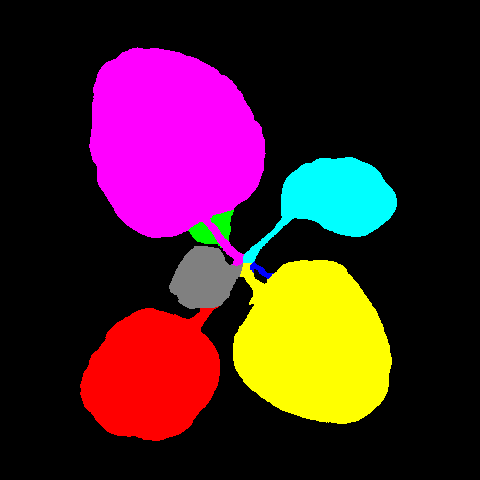

In [ ]:
mask, watershed_image, threshold_image = HSV_filtering_and_watershed(cv.imread('/content/multi_plant/rgb_00_03_007_00.png'), low_H, low_S, low_V, high_H, high_S, high_V)

from google.colab.patches import cv2_imshow
cv2_imshow(threshold_image)
cv2_imshow(watershed_image) # Use cv2_imshow instead of cv.imshow
cv2_imshow(cv.imread('/content/multi_plant/rgb_00_03_007_00.png'))
cv2_imshow(cv.imread('/content/multi_label/label_00_03_007_00.png'))

In [ ]:
# Get a list of all image files in the multi_plant directory
image_files = [f for f in os.listdir('/content/multi_plant') if f.endswith(('.png', '.jpg', '.jpeg'))]

# Create an output directory if it doesn't exist
output_dir = '/content/masked_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Iterate through each image file
for image_file in image_files:
    # Construct the full image path
    image_path = os.path.join('/content/multi_plant', image_file)

    # Read the image
    image = cv.imread(image_path)

    # Apply the function
    mask, _, _ = HSV_filtering_and_watershed(image, low_H, low_S, low_V, high_H, high_S, high_V)

    #Construct the output file name
    output_file_name = image_file.replace('rgb', 'masked')

    # Save the masked image
    output_path = os.path.join(output_dir, output_file_name)
    cv.imwrite(output_path, mask)

In [ ]:
from PIL import Image
import numpy as np

def estimate_leaf(image_path):
  colors_to_exclude = [(0, 0, 0)]  # Exclude black
  image = Image.open(image_path)
  image_array = np.array(image)
  flattened_array = image_array.reshape(-1, image_array.shape[2])
  unique_colors = np.unique(flattened_array, axis=0)
  unique_colors = [tuple(color) for color in unique_colors if tuple(color) not in colors_to_exclude]
  return len(unique_colors)

count = estimate_leaf('/content/masked_images/masked_00_00_000_00.png')
print(count)

2


In [ ]:
import os
import csv

csv_file_path = '/content/leaf_counts.csv'
with open(csv_file_path, 'w', newline='') as csvfile:
    fieldnames = ['image_name', 'leaf_count']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    # Iterate through masked images directory
    masked_images_dir = '/content/masked_images'
    for filename in os.listdir(masked_images_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(masked_images_dir, filename)
            try:
                leaf_count = estimate_leaf(image_path)
                writer.writerow({'image_name': filename, 'leaf_count': leaf_count})
            except Exception as e:
                print(f"Error processing {filename}: {e}")
                writer.writerow({'image_name': filename, 'leaf_count': 'Error'}) # Write 'Error' if processing fails

In [ ]:
import cv2 as cv
import numpy as np

def dice_coefficient(mask_path, label_path):
  # Read the images from the provided paths
  mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
  label = cv.imread(label_path, cv.IMREAD_GRAYSCALE)

  # Ensure both masks are binary
  mask = np.where(mask > 0, 1, 0)
  label = np.where(label > 0, 1, 0)

  intersection = np.logical_and(mask, label).sum()
  union = mask.sum() + label.sum()

  if union == 0:
    return 0  # Handle the case where both masks are empty

  return 2 * intersection / union

In [ ]:
test_mask = '/content/masked_images/masked_00_02_009_02.png'
test_label = '/content/multi_label/label_00_02_009_02.png'

print(dice_coefficient(test_mask, test_label))

0.9809137985697679


In [ ]:
# Define the paths to the mask and label directories
mask_dir = '/content/masked_images'
label_dir = '/content/multi_label'

# Create a dictionary to store the similarity scores for each plant ID
similarity_scores = {}

# Iterate through all image files in the mask directory
for mask_file in os.listdir(mask_dir):
    # Extract components from the mask file name (assuming similar format to labels)
    parts = mask_file.split('_')
    camera_id = parts[1]
    plant_id = parts[2]
    day_id = parts[3]
    time_id = parts[4].split('.')[0]  # Remove the file extension

    # Construct the label file name using the extracted components
    label_file_name = f'label_{camera_id}_{plant_id}_{day_id}_{time_id}.png'

    # Construct the paths to the mask and label images
    mask_image_path = os.path.join(mask_dir, mask_file)
    label_image_path = os.path.join(label_dir, label_file_name)

    # Calculate the similarity score and store it in the dictionary
    score = dice_coefficient(mask_image_path, label_image_path)

    if plant_id not in similarity_scores:
        similarity_scores[plant_id] = []
    similarity_scores[plant_id].append(score)

In [ ]:
# Calculate and print the mean, minimum, and maximum scores for each plant ID
all_means = []
all_mins = []
all_maxs = []

for plant_id in sorted(similarity_scores.keys()):
    scores = similarity_scores[plant_id]  # Get the scores for the current plant ID
    mean_score = np.mean(scores)
    min_score = np.min(scores)
    max_score = np.max(scores)
    print(f"Plant ID: {plant_id}, Mean Score: {mean_score:.4f}, Min Score: {min_score:.4f}, Max Score: {max_score:.4f}")

    all_means.append(mean_score)
    all_mins.append(min_score)
    all_maxs.append(max_score)

# Calculate average mean, average min, and average max separately
avg_mean = np.mean(all_means)
avg_min = np.mean(all_mins)
avg_max = np.mean(all_maxs)

print(f"\nAverage Mean: {avg_mean:.4f}")
print(f"Average Min: {avg_min:.4f}")
print(f"Average Max: {avg_max:.4f}")

Plant ID: 00, Mean Score: 0.9230, Min Score: 0.6846, Max Score: 0.9767
Plant ID: 01, Mean Score: 0.9433, Min Score: 0.8750, Max Score: 0.9785
Plant ID: 02, Mean Score: 0.9269, Min Score: 0.7818, Max Score: 0.9848
Plant ID: 03, Mean Score: 0.9191, Min Score: 0.7183, Max Score: 0.9661
Plant ID: 04, Mean Score: 0.9355, Min Score: 0.8022, Max Score: 0.9694

Average Mean: 0.9296
Average Min: 0.7724
Average Max: 0.9751


In [ ]:
def count_leaf_size(image_path):
  image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

  leaf_size = cv.countNonZero(image)
  return leaf_size

In [ ]:
import re
from scipy.interpolate import interp1d

# Create a dictionary to store data for each plant ID
plant_id_data = {}

# Loop through images in mask_dir directory
for filename in sorted(os.listdir(mask_dir)):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        # Extract plant ID, camera ID, and timestamp using regular expression
        match = re.search(r'masked_(\d{2})_(\d{2})_(\d{3})_(\d{2})', filename)
        if match:
            camera_id = int(match.group(1))
            plant_id = int(match.group(2))
            day_id = int(match.group(3))
            time_id = int(match.group(4))

            # Calculate timestamp (assuming day 0 starts at 3 PM)
            timestamp = day_id * 24 + time_id * 4 + 15

            leaf_size = count_leaf_size(os.path.join(mask_dir, filename))

            # Add data to the plant_id_data dictionary
            key = (plant_id, timestamp)
            if key not in plant_id_data:
                plant_id_data[key] = []
            plant_id_data[key].append(leaf_size)

# Calculate average pixel count for each plant ID and timestamp
average_pixel_counts = {}
for (plant_id, timestamp), counts in plant_id_data.items():
    average_count = np.mean(counts)
    average_pixel_counts[(plant_id, timestamp)] = average_count

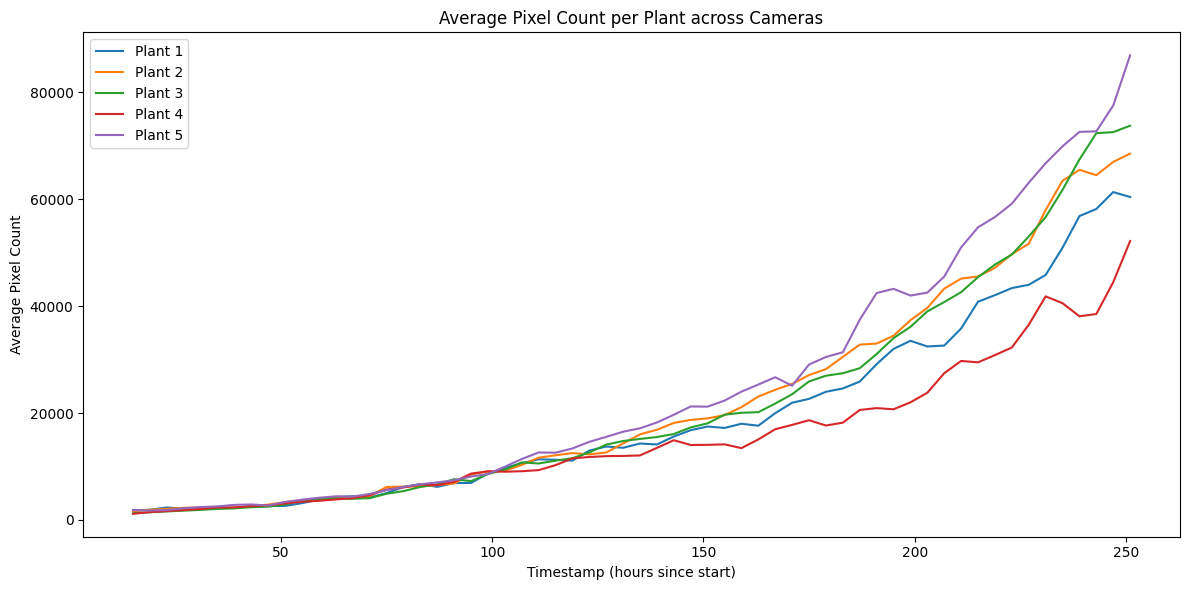

In [ ]:
# Plot the average pixel counts
plt.figure(figsize=(12, 6))
plant_ids = sorted(list(set(plant_id for plant_id, _ in average_pixel_counts)))

for plant_id in plant_ids:
    timestamps = sorted(list(set(timestamp for p_id, timestamp in average_pixel_counts if p_id == plant_id)))
    counts = [average_pixel_counts[(plant_id, timestamp)] for timestamp in timestamps]
    plt.plot(timestamps, counts, label=f'Plant {plant_id + 1}')

plt.xlabel('Timestamp (hours since start)')
plt.ylabel('Average Pixel Count')
plt.title('Average Pixel Count per Plant across Cameras')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
!zip -r /content/masked_images.zip /content/masked_images

  adding: content/masked_images/ (stored 0%)
  adding: content/masked_images/masked_02_01_007_02.png (deflated 35%)
  adding: content/masked_images/masked_01_01_002_01.png (deflated 58%)
  adding: content/masked_images/masked_00_01_002_05.png (deflated 50%)
  adding: content/masked_images/masked_00_00_009_02.png (deflated 33%)
  adding: content/masked_images/masked_02_04_004_02.png (deflated 44%)
  adding: content/masked_images/masked_00_01_006_03.png (deflated 36%)
  adding: content/masked_images/masked_01_03_001_04.png (deflated 56%)
  adding: content/masked_images/masked_00_00_002_00.png (deflated 52%)
  adding: content/masked_images/masked_00_02_005_05.png (deflated 38%)
  adding: content/masked_images/masked_00_04_007_04.png (deflated 37%)
  adding: content/masked_images/masked_00_03_004_04.png (deflated 44%)
  adding: content/masked_images/masked_00_00_000_05.png (deflated 62%)
  adding: content/masked_images/masked_02_03_000_04.png (deflated 60%)
  adding: content/masked_images/

# SAM
